In [1]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 KB 2.3 MB/s eta 0:00:00


# Explaination of the code

The following notebook consits of two types of networks. One is where the input data is static and other where rate coding has been done.

In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
import torch.quantization
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. Surrogate Gradient Descent
This will only be requried if we are doing black and white. Currently we will concentrate on grayscale image. Hence, this is not used.


In [3]:
threshold_value_for_black_and_white=0.4
num_steps = 50 #Try to minimize this
beta=0.5 #try to put it in values of 2 for easier representation in fixed point
lif1 = snn.Leaky(beta=beta)

There are multiple approximation which can be considred in SNN training. One of them is sigmoid.

https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html

Better yet, all of that can be condensed by using the built-in module `snn.surrogate` from snnTorch, where $k$ from $(4)$ is denoted `slope`. The surrogate gradient is passed into `spike_grad` as an argument:

In [4]:
spike_grad = surrogate.spike_rate_escape(slope=25)#Can play around with the slope value too


To explore the other surrogate gradient functions available, [take a look at the documentation here.](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html)

# 2. Setting up the CSNN
## 2.1 DataLoaders
Note that `utils.data_subset()` is called to reduce the size of the dataset by a factor of 10 to speed up training.

In [5]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'
subset=1

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

Here is the dimension of each variable used in the code:

1. mnist_train: This is a PyTorch Dataset object with dimensions [number of samples, height, width].
2. mnist_test: This is also a PyTorch Dataset object with the same dimensions as mnist_train.
3. train_loader: This is a PyTorch DataLoader object that provides access to the mnist_train dataset in minibatches of size batch_size. The dimensions of a single minibatch is [batch_size, height, width].
4. test_loader: This is a PyTorch DataLoader object that provides access to the mnist_test dataset in minibatches of size batch_size. The dimensions of a single minibatch is [batch_size, height, width].
5. data: This is an iterator over the minibatches of the train_loader object.
6. data_it: This is a minibatch from the data iterator, with dimensions [batch_size, height, width].
7. targets_it: This is a tensor of targets (the labels) corresponding to the images in the data_it minibatch. The dimensions of this tensor is [batch_size].
8. spike_data: This is the result of applying the spikegen.rate function on the data_it minibatch. The dimensions of this tensor is [batch_size, num_steps, height, width].

In [6]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,)),
            #ThresholdTransform(thr_255=threshold_value_for_black_and_white)
            ])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
# # reduce datasets by 10x to speed up training
# utils.data_subset(mnist_train, subset)
# utils.data_subset(mnist_test, subset)
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



This code defines a transform for pre-processing the MNIST data, using the torchvision.transforms module. The transform consists of the following operations, performed in the specified order:

1. Resize the image to 28x28 pixels.
2. Convert the image to grayscale.
3. Convert the image to a tensor.
4. Normalize the tensor values to zero-mean and unit-variance.

The transformed data is used to create two datasets: mnist_train for the training set and mnist_test for the test set. The datasets.MNIST constructor is used for this purpose, where data_path is the path where the data should be stored. The train argument is set to True for the training set and False for the test set. The download argument is set to True to download the data if it's not already available locally. The transform argument is set to the transform defined above.

Finally, the code creates two data loaders, train_loader and test_loader, using the torch.utils.data.DataLoader class. The data loaders take the respective datasets as inputs, and divide them into batches of size batch_size, randomly shuffling the data samples and dropping the last batch if it has fewer than batch_size samples.

In [7]:
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
time=1e-3
print(data_it.size())
print(targets_it.size())
print(data_it[1][0])


torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.5804, 0.7176, 0.7490,
        

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
time=1e-3
print(data_it.size())
print(targets_it.size())

In [8]:
print(targets_it[1])

tensor(2)


This code is creating a custom Dataset called SpikeDataset which will be used to store the data that has been converted to spikes using the spikegen.rate function.

The custom dataset class is derived from the PyTorch Dataset class and implements the required methods __init__, __len__ and __getitem__.

The __init__ method initializes the dataset with three inputs: data, target, and num_steps. The data and target input arguments store the data and target data. The num_steps argument is used to specify the number of steps for the spiking process.

The __len__ method returns the length of the data.

The __getitem__ method returns a single item from the dataset, it takes an index idx as an input argument, and it returns the spiking data and the target data for the idxth item. The spiking data is generated using the spikegen.rate function and the target data is directly taken from the input argument target.

Finally, a SpikeDataset object is created by passing the data, target, and num_steps to the SpikeDataset class. This object is then passed to the PyTorch DataLoader to create a data loader object spike_data_loader. This data loader can be used to iterate over the spike dataset.






In [9]:
import torch
import snntorch.spikegen as spikegen

# Create custom Pytorch Dataset class
class SpikeDataset(torch.utils.data.Dataset):
    def __init__(self, data_loader, num_steps):
        self.data_loader = data_loader
        self.num_steps = num_steps

    def __len__(self):
        return len(self.data_loader)

    def __getitem__(self, idx):
        data, targets = self.data_loader[idx]
        spiking_data = spikegen.rate(data, num_steps=self.num_steps)
        return (spiking_data, targets)



This part of code is used to convert the above data to rate coding

In [10]:
# Create SpikeDataset object
spike_dataset = SpikeDataset(mnist_train, num_steps)

# Create a data loader for the SpikeDataset
spike_data_loader = DataLoader(spike_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

spike_dataset_test = SpikeDataset(mnist_test, num_steps)
spike_data_test_loader = DataLoader(spike_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
print(len(spike_data_loader))
print(len(train_loader))
print(len(test_loader))
print(len(spike_data_test_loader))

468
468
78
78


In [12]:
# Iterate through minibatches
data_spike = iter(spike_data_loader)
data_spike_it, targets_it = next(data_spike)
time=1e-3
print(data_spike_it.size())
print(targets_it.size())

torch.Size([128, 50, 1, 28, 28])
torch.Size([128])


In [13]:
print(data_spike_it[1][0])
print(targets_it[1])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
          1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,

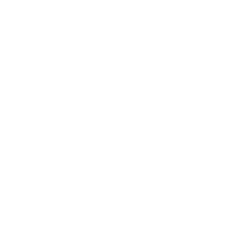

In [14]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
fig, ax = plt.subplots()
anim = splt.animator(data_spike_it[1][0], fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

## 2.2 Define the Network

The convolutional network architecture to be used is: 12C5-MP2-64C5-MP2-1024FC10

- 12C5 is a 5$\times$5 convolutional kernel with 12 filters
- MP2 is a 2$\times$2 max-pooling function
- 1024FC10 is a fully-connected layer that maps 1,024 neurons to 10 outputs

In [15]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

In the previous tutorial, the network was wrapped inside of a class, as shown above. 
With increasing network complexity, this adds a lot of boilerplate code that we might wish to avoid. Alternatively, the `nn.Sequential` method can be used instead:

In [16]:
#  Initialize Network
#https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
#A sequential container. Modules will be added to it in the order they are passed in the constructor.
#Alternatively, an OrderedDict of modules can be passed in. The forward() method of Sequential accepts 
#any input and forwards it to the first module it contains.
# It then “chains” outputs to inputs sequentially for each subsequent module, finally returning the output of the last module.
net = nn.Sequential(nn.Conv2d(1, 6, 5,bias=False),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(6*12*12, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)


The `init_hidden` argument initializes the hidden states of the neuron (here, membrane potential). This takes place in the background as an instance variable. 
If `init_hidden` is activated, the membrane potential is not explicitly returned to the user, ensuring only the output spikes are sequentially passed through the layers wrapped in `nn.Sequential`. 

To train a model using the final layer's membrane potential, set the argument `output=True`. 
This enables the final layer to return both the spike and membrane potential response of the neuron.

## 2.3 Forward-Pass
A forward pass across a simulation duration of `num_steps` looks like this:

Here the variables are redefined for a clearer picture:
1. **data**: Is basically where all the grayscale pixel is store i.e 128x1x28x28 where 128 is batch size, 1 is channel, 28x28 is pixel
2. **targets**: Is the corresponding digit, hence size of 128
3. **spike_data**: Is the training data converted to rate encoded spikes implies 128x50x28x28
4. **targets_spike**: Is the digit corresponding to the rate encoded data
5. **spike_data_test**: Is the testing data converted to rate encoded spikes implies 128x50x28x28
6. **targets_spike_test**:Is the digit corresponding to the rate encoded data

In [17]:
spike_data, targets_spike=next(iter(spike_data_loader))
spike_data = spike_data.to(device)
targets_spike = targets_spike.to(device)

In [18]:
spike_data_test, targets_spike_test=next(iter(spike_data_test_loader))
spike_data_test = spike_data_test.to(device)
targets_spike_test = targets_spike_test.to(device)

In [19]:
print(spike_data.size())
print(spike_data_test.size())

torch.Size([128, 50, 1, 28, 28])
torch.Size([128, 50, 1, 28, 28])


Here in the forward pass for the net(), each data would be passed out till the given time step. As the spike_data is stored as 128xtime_stepx28x28, to access the data spike_data(:,step) is given. Note, the spk_out is an array which will store all 10 outputs. This code is more for checking purposes for the main forward_pass data and can be ignored. 

This is the forward_pass for the not coded data, hence the same data is being kept passed.

Wrap that in a function, recording the membrane potential and spike response over time:

This is the forward pass for the rate encoded data and it saves the value in each time_step in spk_rec.

In [20]:
def forward_pass_spike(net, num_steps, spike_data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(spike_data[:,step])
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
  
  return torch.stack(spk_rec), torch.stack(mem_rec)

In [21]:
spk_rec_spikedata, mem_rec_spikedata = forward_pass_spike(net, num_steps, spike_data)

# 3. Training Loop

## 3.1 Loss Using snn.Functional

In the previous tutorial, the Cross Entropy Loss between the membrane potential of the output neurons and the target was used to train the network. 
This time, the total number of spikes from each neuron will be used to calculate the Cross Entropy instead.

A variety of loss functions are included in the `snn.functional` module, which is analogous to `torch.nn.functional` in PyTorch. 
These implement a mix of cross entropy and mean square error losses, are applied to spikes and/or membrane potential, to train a rate or latency-coded network. 

The approach below applies the cross entropy loss to the output spike count in order train a rate-coded network:

Alternates to it are snntorch.functional.loss.mse_count_loss

In [22]:
# already imported snntorch.functional as SF 
loss_fn = SF.ce_rate_loss()

# This is a loss function and can be modified. 
Other options are:

The recordings of the spike are passed as the first argument to `loss_fn`, and the target neuron index as the second argument to generate a loss. [The documentation provides further information and exmaples.](https://snntorch.readthedocs.io/en/latest/snntorch.functional.html#snntorch.functional.ce_rate_loss)

In [23]:
loss_val = loss_fn(spk_rec_spikedata, targets_spike)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


In [24]:
loss_val = loss_fn(spk_rec_spikedata, targets_spike)
print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


## 3.2 Accuracy Using snn.Functional
The `SF.accuracy_rate()` function works similarly, in that the predicted output spikes and actual targets are supplied as arguments. `accuracy_rate` assumes a rate code is used to interpret the output by checking if the index of the neuron with the highest spike count matches the target index.

In [25]:
acc = SF.accuracy_rate(spk_rec_spikedata, targets_spike)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 10.156%


As the above function only returns the accuracy of a single batch of data, the following function returns the accuracy on the entire DataLoader object:

In [26]:
def batch_accuracy_spike(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    
    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass_spike(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
test_acc = batch_accuracy_spike(spike_data_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

## 3.3 Training Automation Using snn.backprop

Training SNNs can become arduous even with simple networks, so the `snn.backprop` module is here to reduce some of this effort.

The `backprop.BPTT` function automatically performs a single epoch of training, where you need only provide the training parameters, dataloader, and several other arguments. 
The average loss across iterations is returned. 
The argument `time_var` indicates whether the input data is time-varying. 
As we are using the MNIST dataset, we explicitly specify `time_var=False`. 

The following code block may take a while to run. If you are not connected to GPU, then consider reducing `num_epochs`.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 30
test_acc_hist = []

# training loop
for epoch in range(num_epochs):

    avg_loss = backprop.BPTT(net, spike_data_loader, optimizer=optimizer, criterion=loss_fn, time_var=True, device=device,time_first=False)
    
    print(f"Epoch {epoch}, Train Loss: {avg_loss.item():.2f}")

    # Test set accuracy
    test_acc = batch_accuracy_spike(spike_data_loader, net, num_steps)
    test_acc_hist.append(test_acc)

    print(f"Epoch {epoch}, Test Acc: {test_acc * 100:.2f}%\n")

The next below is for static dataset not rate encode. Uncomment to use these


Despite having selected some fairly generic values and architectures, the test set accuracy should be fairly competitive given the brief training run!

# 4. Results
## 4.1 Plot Test Accuracy

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 4.2 Spike Counter

Run a forward pass on a batch of data to obtain spike and membrane readings.

In [ ]:
test_acc = batch_accuracy_spike(spike_data_test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
min_val = float('inf')
max_val = float('-inf')
# maximum values
max_vals = []
# minimum values
min_vals = []
spk_out, mem_out = forward_pass_spike(net, num_steps, spike_data)

min_val = min(min_val, mem_out.min().item())
max_val = max(max_val, mem_out.max().item())
max_vals.append(max_val)
min_vals.append(min_val)

print(f"Minimum value: {min_val}")
print(f"Maximum value: {max_val}")
# Plotting the maximum and minimum values
plt.plot(max_vals)
plt.plot(min_vals)
plt.xlabel("Example number")
plt.ylabel("Value")
plt.legend(["Maximum", "Minimum"])
plt.show()


In [ ]:
def from_fixed_point(x, q_point=7, q_min=-1, q_max=1):
    """Convert fixed point representation to float tensor.

    Args:
        x (torch.Tensor): Input tensor.
        q_point (int): Number of fractional bits.
        q_min (int): Minimum value of fixed point representation.
        q_max (int): Maximum value of fixed point representation.

    Returns:
        torch.Tensor: Float representation of x.
    """
    scale = (q_max - q_min) / ((1 << q_point) - 1)
    x = x * scale
    return x


In [ ]:
import numpy as np

def fixed_point(value, q_point=7, q_min=-1, q_max=1):
    scale = 2**q_point
    quantized_value = int(round(value * scale))
    return quantized_value

# Assume you have a trained network 'net'
params = net.state_dict()
for name, param in params.items():
    if param.ndimension() == 0:
        value = param.item()
        q_value = fixed_point(value)
        print(f'{name} Shape: () Value: {value} Q1.7: {np.binary_repr(q_value, width=8)}')
    else:
        values = param[:3].flatten().tolist()
        q_values = [fixed_point(value) for value in values]
        print(f'{name} Shape: {param.shape} Values: {values} Q1.7: {[np.binary_repr(q_value, width=8) for q_value in q_values]}')


In [ ]:

# Save the model
torch.save(net.state_dict(), "csnn_model.pt")


Changing `idx` allows you to index into various samples from the simulated minibatch. Use `splt.spike_count` to explore the spiking behaviour of a few different samples!

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)